# Statistical Test for Price with other Variables 

In earlier EDA, we have seen many factors can contribute to cosmetic products' price. Here we will use statistical test to evaluate the significance of these variables. We will look at:

* Product Category
* Brand
* Ingredient
    * Number of ingredient
    * Ingredient rating
    * Ingredient category
    * Individule ingredient

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

import sys
sys.path.append('../utilities')
from data_utils import *
from stats_utils import *

Read data and clean a little bit.

In [2]:
# read cleaned data
skin_care_df = pd.read_csv('../data_cleaning/skin_care_cleaned.csv')
body_care_df = pd.read_csv('../data_cleaning/body_care_cleaned.csv')
makeup_df = pd.read_csv('../data_cleaning/makeup_cleaned.csv')

# merge skin-care, body-care and makeup table
merged_df = pd.concat([skin_care_df,body_care_df,makeup_df], sort=False).reset_index(drop=True)

# rename some columns so the formular for statsmodel can work
for col in merged_df.columns.values:
    col_new = col.replace(' ','_').replace('-','_').replace(':','').replace('/','_')
    merged_df.rename({col : col_new}, axis=1, inplace=True)
    skin_care_df.rename({col : col_new}, axis=1, inplace=True)
    body_care_df.rename({col : col_new}, axis=1, inplace=True)
    makeup_df.rename({col : col_new}, axis=1, inplace=True)

# drop outlier
skin_care_df = skin_care_df.loc[merged_df['price']<1000]
merged_df = merged_df.loc[merged_df['price']<1000]

### ANOVA test for product category

In [3]:
model = ols('price ~ product_category', data=merged_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
product_category,2.750433e+06,38.0,48.535296,0.0
Residual,1.209877e+07,8113.0,NaN,NaN


The large F-statistic and small p-value tells us at least one product category has different price distribution with the others, but it didn't tell us which category. So to get more information, we can try to do pair-wise t-test.

Do pairwise t-test to compare group means for the six largest categories.

In [4]:
def pairwise_t(df, groups, x, y):
    
    ts = pd.DataFrame(index=groups, columns=groups)
    p_values = pd.DataFrame(index=groups, columns=groups)
    
    for i in groups:
        values_i = df[y].loc[df[x]==i]
        for j in groups:
            values_j = df[y].loc[df[x]==j]
            t, p_value = stats.ttest_ind(values_i, values_j)
            ts.loc[i,j] = t
            p_values.loc[i,j] = p_value
    return ts.astype('float'), p_values.astype('float')

categories = ['Nighttime Moisturizer', 'Cleansers', 'Serum', 'Exfoliants', 'Lip Stick/Gloss/Liner', 'Eye Cream & Treatment']
ts, p_values = pairwise_t(merged_df, categories, 'product_category', 'price')
p_values

,Nighttime Moisturizer,Cleansers,Serum,Exfoliants,Lip Stick/Gloss/Liner,Eye Cream & Treatment
Nighttime Moisturizer,1.000000e+00,1.328984e-56,3.059038e-09,3.499499e-13,2.310472e-36,7.287101e-01
Cleansers,1.328984e-56,1.000000e+00,1.061164e-83,1.108291e-27,1.671774e-03,9.587487e-67
Serum,3.059038e-09,1.061164e-83,1.000000e+00,3.755558e-29,2.743172e-51,1.389795e-07
Exfoliants,3.499499e-13,1.108291e-27,3.755558e-29,1.000000e+00,1.066692e-35,2.316864e-15
Lip Stick/Gloss/Liner,2.310472e-36,1.671774e-03,2.743172e-51,1.066692e-35,1.000000e+00,7.284636e-50
Eye Cream & Treatment,7.287101e-01,9.587487e-67,1.389795e-07,2.316864e-15,7.284636e-50,1.000000e+00


So from the p-values, we see that it is hard to distinguish the price of nighttime moisturizers and eye cream & treatment, the second hard pair would be cleansers and lip stick/gloss/liner. The other categories are distinguishable. Also visualize the p-values using heatmaps, with the sign of t-values encoded so that red block indicates the row category is cheaper than the column category, blue indicates that row category is more expensive than the column category. Also, darker color means the two brand is easy to tell apart (distinguishable). From the heatmap, it is clear to see that serums are the most expensive among the six categories and lip products are the cheapest.

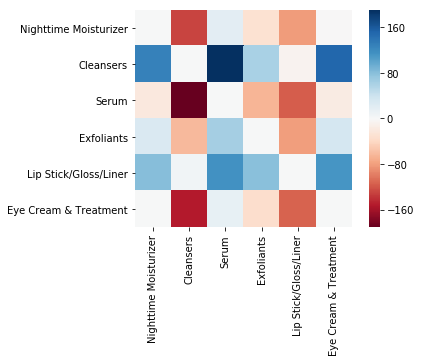

In [5]:
ax=sns.heatmap(ts.apply(np.sign) * p_values.apply(np.log), cmap="RdBu")
ax.set_aspect("equal")
plt.show()

### ANOVA test for brand

In [6]:
skin_care_df = skin_care_df.drop(['product_category'],axis=1).drop_duplicates()
body_care_df = body_care_df.drop(['product_category'],axis=1).drop_duplicates()
makeup_df = makeup_df.drop(['product_category'],axis=1).drop_duplicates()
df = merged_df.drop(['product_category'],axis=1).drop_duplicates()

In [7]:
model = ols('price ~ brand', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
brand,7.065262e+06,245.0,29.52346,0.0
Residual,7.412752e+06,7589.0,NaN,NaN


As we expected, price also varies with brand. Again, we can do pairwise t-test on the six largest brand (large means having more product in the dataset).

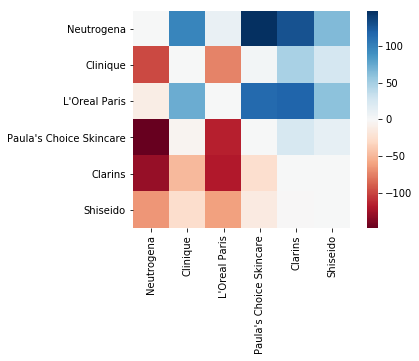

In [8]:
brands = ["Neutrogena", "Clinique", "L'Oreal Paris", "Paula's Choice Skincare", "Clarins", "Shiseido"]
ts, p_values = pairwise_t(df, brands, 'brand', 'price')

ax=sns.heatmap(ts.apply(np.sign) * p_values.apply(np.log), cmap="RdBu")
ax.set_aspect("equal")
plt.show()

So, we find Clarins and Shiseido are the most expensive brands of the six, and hard to distinguish among themselves, Neutrogena is the cheapest.

### Tests For ingredient

drop products without ingredient information.

In [9]:
skin_care_df = skin_care_df.loc[~skin_care_df['ingredient'].isnull()]
body_care_df = body_care_df.loc[~body_care_df['ingredient'].isnull()]
makeup_df = makeup_df.loc[~makeup_df['ingredient'].isnull()]
df = df.loc[~df['ingredient'].isnull()]

#### Slope test for number of ingredients

In the EDA we have done earlier, we found price seem to be positively correlated with number of ingredient, and the effect is stronger in skin care products. We will examine the statistic significance using slope tests on the number of ingredient.

In [10]:
n_ingredient_lr = lr_stats(skin_care_df, ['n_inactive_ingredient', 'n_active_ingredient'], 'price')
n_ingredient_lr

,slope,intercept,r-value,p-value,stderr
n_inactive_ingredient,1.411541,1.843835,0.422174,2.486091e-204,0.044024
n_active_ingredient,-3.977432,45.030912,-0.100219,4.615315e-12,0.573548


In [11]:
n_ingredient_lr = lr_stats(body_care_df, ['n_inactive_ingredient', 'n_active_ingredient'], 'price')
n_ingredient_lr

,slope,intercept,r-value,p-value,stderr
n_inactive_ingredient,0.653414,4.328185,0.365107,2.092115e-14,0.082383
n_active_ingredient,-2.685770,21.636582,-0.091174,6.480587e-02,1.450524


In [12]:
n_ingredient_lr = lr_stats(makeup_df, ['n_inactive_ingredient', 'n_active_ingredient'], 'price')
n_ingredient_lr

,slope,intercept,r-value,p-value,stderr
n_active_ingredient,4.390372,23.642493,0.215471,1.513474e-13,0.587243
n_inactive_ingredient,0.106137,23.037426,0.188668,1.125176e-10,0.016305


Surperisingly, we see even in body care and makeup products, the number of ingredients have statistical significant with price, although the p-values are larger compare to that in skin care products. It could be the case of small practical significance but large statistical significance. The r-values are small, so the underlining correlation may be buried under large variance. Also, the number of active ingredient in skin care is negatively correlated with price, the reason might be that the products containing active ingredient such as sunscreens are cheaper categories.

#### Slope test for ingredient rating

From the statistic test, we see that the rating for inactive ingredients do has statistical significance with price, which is not obvious on the rating-price scatter plot we have in EDA earlier. Again, it could be the case of small practical significance but large statistical significance, the slopes are large (meaning the fitted lines are almost vertical), and for makeup and body care, the slopes are negative.

In [13]:
ingredient_rating_lr = lr_stats(skin_care_df, 
      ['active_mean_rating', 'inactive_mean_rating', 'inactive_mean_rating_w1',
       'inactive_mean_rating_w2'], 'price')
ingredient_rating_lr

,slope,intercept,r-value,p-value,stderr
inactive_mean_rating_w2,20.322263,0.513893,0.090938,3.529875e-10,3.232481
inactive_mean_rating,9.414113,24.068103,0.044380,2.237252e-03,3.078064
inactive_mean_rating_w1,9.704776,22.832209,0.044302,2.277805e-03,3.178709
active_mean_rating,1.654890,24.014539,0.024799,4.569443e-01,2.223690


In [14]:
ingredient_rating_lr = lr_stats(body_care_df, 
      ['active_mean_rating', 'inactive_mean_rating', 'inactive_mean_rating_w1',
       'inactive_mean_rating_w2'], 'price')
ingredient_rating_lr

,slope,intercept,r-value,p-value,stderr
inactive_mean_rating,-9.369667,39.668326,-0.125456,0.010906,3.663745
inactive_mean_rating_w1,-10.961972,44.133897,-0.118561,0.016183,4.539542
inactive_mean_rating_w2,-7.643259,37.048135,-0.093014,0.059560,4.045567
active_mean_rating,0.700230,12.633702,0.039521,0.789704,2.610339


In [15]:
ingredient_rating_lr = lr_stats(makeup_df, 
      ['active_mean_rating', 'inactive_mean_rating', 'inactive_mean_rating_w1',
       'inactive_mean_rating_w2'], 'price')
ingredient_rating_lr

,slope,intercept,r-value,p-value,stderr
inactive_mean_rating,-10.924508,49.126122,-0.158218,6.905827e-08,2.012195
inactive_mean_rating_w1,-8.690319,44.310998,-0.126461,1.699339e-05,2.011901
inactive_mean_rating_w2,-8.752620,44.428035,-0.121694,3.507453e-05,2.106971
active_mean_rating,5.377138,17.863909,0.064050,3.443678e-01,5.674309


#### F-test for ingredient category count

We will use statsmodel to perform linear regression on ingredient category count features. The model summary reports a large F-statistic, which indicates at least one of the features should have none zeros slope. It also report the t-statitic for each feature, which can help us identify possible features that have significant influence on price.

In [16]:
inactive_cat_count = [f_ for f_ in df.columns.values if f_.find('inactive_cat_count')>=0]
fitting_formula = "price ~ " + " + ".join(inactive_cat_count)
model = ols(fitting_formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     68.03
Date:                Thu, 25 Oct 2018   Prob (F-statistic):               0.00
Time:                        00:59:14   Log-Likelihood:                -32269.
No. Observations:                6303   AIC:                         6.460e+04
Df Residuals:                    6273   BIC:                         6.480e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             15.1366      1.032     14.670      0.000      13.114      17.159
inactive_cat_count_Absorbent                                          -2.2829      0.526     -4.337      0.000      -3.315      -1.251
inactive_cat_count_Anti_Acne                                         -10.2467      2.628     -3.899      0.000     -15.398      -5.095
inactive_cat_count_Antioxidants                                        2.6827      0.274      9.790      0.000       2.146       3.220
inactive_cat_count_Cleansing_Agents                                   -1.4236      0.316     -4.503      0.000      -2.043      -0.804
inactive_cat_count_Coloring_Agents_Pigments                            0.0865      0.216      0.400      0.689      -0.337       0.510
inactive_cat_count_Emollients                                          0.0208      0.219      0.095      0.924      -0.408       0.450
inactive_cat_count_Emulsifiers                                        -1.7034      0.831     -2.049      0.041      -3.333      -0.074
inactive_cat_count_Exfoliant                                           3.4247      1.066      3.213      0.001       1.335       5.514
inactive_cat_count_Film_Forming_Agents                                 2.8323      2.124      1.334      0.182      -1.331       6.995
inactive_cat_count_Film_Forming_Holding_Agents                         1.9491      0.882      2.209      0.027       0.220       3.679
inactive_cat_count_Fragrance_Synthetic_and_Fragrant_Plant_Extracts     2.2986      0.391      5.880      0.000       1.532       3.065
inactive_cat_count_Hydration                                           2.6824      0.677      3.964      0.000       1.356       4.009
inactive_cat_count_Miscellaneous                                      -0.2253      0.484     -0.466      0.641      -1.173       0.723
inactive_cat_count_Plant_Extracts                                     -1.6197      0.213     -7.593      0.000      -2.038      -1.202
inactive_cat_count_Preservatives                                       1.4195      0.285      4.987      0.000       0.861       1.978
inactive_cat_count_Scrub_Agents                                       -5.3489      1.076     -4.970      0.000      -7.459      -3.239
inactive_cat_count_Sensitizing                                         1.3914      0.504      2.761      0.006       0.403       2.379
inactive_cat_count_Silicones                                           0.1563      0.411      0.380      0.704      -0.649       0.962
inactive_cat_count_Skin_Replenishing                                  -1.4693      0.348     -4.227      0.000   

So we find the top 5 ingredient categories that have largest (absolute) t-statistic/smallest p-values are:
* Skin Restoring
* Antioxident
* Texture_Enhancer
* Plant Extract
* Fragrance

These match the categories we find in early EDA that have large correlation with price.

#### chi-square test for individule ingredient

We will use chi-square chi square homogeneity test on some "interesting" ingredients --- ingredients that appear in a considerable number of products but are not too common. We do see chi-square test identify a few ingredients which cosmetic companies advertise a lot, such as piptides, retinol, xxx extract...

In [17]:
ingredient_count_df = get_matching_ingredient_count(df)

interesting_ingredients = []
for col in ingredient_count_df.columns.values:
    count_ingredient = ingredient_count_df[col].sum()
    if count_ingredient > 100 and count_ingredient < 500:
       interesting_ingredients.append(col) 
    
price_band, bins = pd.qcut(df['price'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=False, retbins=True)
ingredient_count_df['price_band'] = price_band.reset_index(drop=True)

results = chi2_contingency(ingredient_count_df, interesting_ingredients, 'price_band').sort_values('p-value')
results.head(50)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/contingency.py:242: RuntimeWarning: invalid value encountered in less
  if np.any(observed < 0):


,chi2,p-value
algae extract,229.091766,2.070663e-48
acetyl hexapeptide-8,228.529115,2.736711e-48
yeast extract,214.237668,3.256738e-45
caffeine,213.816742,4.011803e-45
alpha isomethyl ionone,200.687696,2.673117e-42
palmitoyl oligopeptide,184.319258,8.806622e-39
hydrogenated lecithin,174.039805,1.420095e-36
trehalose,160.535621,1.122151e-33
DMDM hydantoin,159.055908,2.330210e-33
phospholipid,149.860032,2.181328e-31


We have identified quite a number of ingredients with pretty small p-values. However, we should keep in mind that when the features are colinear, adding them all together to the machine learning model may not be very helpful because there aren't much new information.